In [60]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy.stats as ss

from disjoint_set import DisjointSet
from dython.nominal import associations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from utils import *

In [93]:
data_folder = "data"
raw_data_csv_fname = "home_ex_raw_data.csv"
data_path = pjoin(data_folder, raw_data_csv_fname)

df = pd.read_csv(data_path, index_col=0)

In [94]:
raw_data = df.set_index("serial_number", drop=True)
features = raw_data.drop(["Diagnosis"], axis=1)
labels = raw_data[["Diagnosis"]]

In [95]:
del(df)
del(raw_data)

In [96]:
index = features.index

features = features.loc[~index.duplicated()]
labels = labels.loc[~index.duplicated()]

In [97]:
dropped_cols = features.T.drop_duplicates().T
dropped_rows = dropped_cols.drop_duplicates()
features = dropped_rows

In [104]:
features = features.dropna()

In [105]:
VAR_THRESH = 0
feat_vars = features.var()
features = features[features.columns[feat_vars > VAR_THRESH]]

In [106]:
labels = labels.loc[features.index]
features.shape, labels.shape

((71563, 1206), (71563, 1))

In [132]:
cat_condition = np.array([(len(features[col].unique())<=100) for col in features])
cat_features = features[features.columns[cat_condition]]
numerical_features = features[features.columns[~cat_condition]]
cat_features.shape, numerical_features.shape

((71563, 828), (71563, 378))

In [133]:
Q1 = numerical_features.quantile(0.25)
Q3 = numerical_features.quantile(0.75)
IQR = Q3 - Q1
iqr_cols = IQR.index
numerical_features = numerical_features[~( (numerical_features[iqr_cols] < (Q1[iqr_cols] - 1.5 * IQR[iqr_cols])) | (numerical_features[iqr_cols] > (Q3[iqr_cols] + 1.5 * IQR[iqr_cols])) ).any(axis=1)]
cat_features = cat_features.loc[numerical_features.index]
labels = labels.loc[numerical_features.index]

cat_features.shape, numerical_features.shape, labels.shape

((48837, 828), (48837, 378), (48837, 1))

In [134]:
from sklearn import preprocessing

In [135]:
numerical_features_scaled = numerical_features - numerical_features.mean()

In [136]:
from sklearn.decomposition import PCA

In [137]:
pca = PCA(n_components=2)
pca.fit(numerical_features_scaled)
X = pca.transform(numerical_features_scaled)

In [138]:
f = X[labels["Diagnosis"]=="False"]
t = X[labels["Diagnosis"]=="True"]

In [156]:
l = f[f[:, 0]>0]

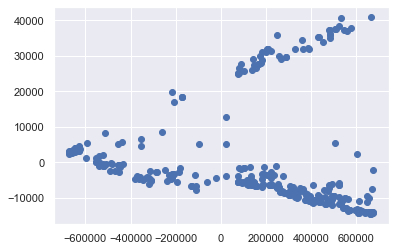

In [141]:
# plt.scatter(f[:, 0], f[:, 1])
plt.scatter(t[:, 0], t[:, 1])

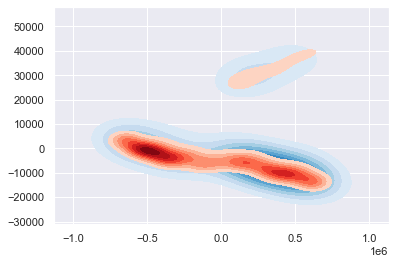

In [165]:
ax = sns.kdeplot(t[:, 0], t[:, 1],
                 cmap="Blues", shade=True, shade_lowest=False)


ax = sns.kdeplot(f[:, 0], f[:, 1],
                 cmap="Reds", shade=True, shade_lowest=False)




In [142]:
from sklearn import mixture


In [ ]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag').fit(t)

Automatically created module for IPython interactive environment


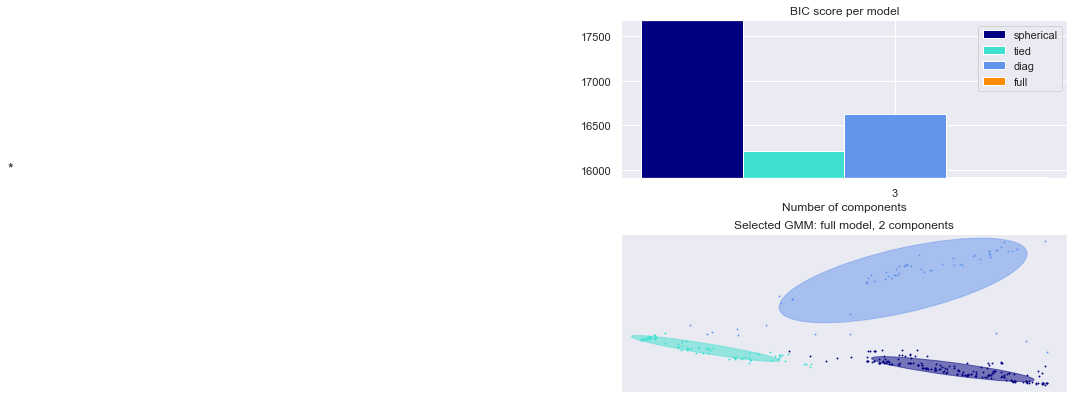

In [167]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
# X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
#           .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

X = t

lowest_bic = np.infty
bic = []
n_components_range = range(3, 4)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()